In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_context_only_dhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [10]:
#exclude c10m6 (dentate animal)
context_only_animals = 'dhpc35','dhpc36'

In [11]:
sessions = ['context_only']

In [13]:
for sess in sessions:

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [14]:
delta_t0 = 1

t_start0 = -8  # sec
t_stop0 = 12  # sec (dhpc35, 36 recorded until 12s post CS onset, and context stopped at 9s)

In [15]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [16]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [17]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [18]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [19]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [20]:
for sess in sessions:
    for t in range(20):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36 context_only dhpc35 context_only dhpc36


### decode all individual trial comparisons

In [27]:
%%time
n_loops=15
comparisons = [1,2],
for compare in comparisons:
#    which_trials = (labels_context_switch==compare[0], labels_context_switch==compare[1]) # make 2 arrays
#    which_trials = which_trials[0]+which_trials[1] #add arrays
############### an alternative strategy #####################   
#    relabel = {1:-1,2:-1,3:-1,4:-1,5:-1,6:-1,7:-1,8:-1,compare[0]:1,compare[1]:0} #set all labels = -1, then relabel pertinent trials
    for t in range(20):
        exec("scores_tb_%s_contextAvsB = {}"%(t))
        print compare[0],"vs",compare[1],#":",t,"   ",
        #for i, (p, l) in enumerate(zip(patterns_tb, labels_tb)):
        eval("scores_tb_%s_contextAvsB"%(t))['context_only'] = np.r_[[do_test_within(eval("patterns_tb_%s_context_only"%t),
                labels_context_only, classes=range(1,3), n_cells=None) for i in range(n_loops)]]

1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2CPU times: user 4.9 s, sys: 12 ms, total: 4.92 s
Wall time: 4.89 s



In [37]:
comparisonsA = ['CSPvsCSM_contextA','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
comparisonsB = ['CSPvsCSM_contextB','CS5vsCS6','CS7vsCS8','CS5vsCS7','CS5vsCS8','CS6vsCS7','CS6vsCS8']
context_comparisons = ['CS1vsCS5','CS2vsCS6','CS3vsCS7','CS4vsCS8']
relabelsA = [{1:0,2:0,3:1,4:1},{1:0,2:1,3:-1,4:-1},{1:-1,2:-1,3:0,4:1},{1:0,2:-1,3:1,4:-1},{1:0,2:-1,3:-1,4:1},{1:-1,2:0,3:1,4:-1},{1:-1,2:0,3:-1,4:1}]
compA_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-']
compB_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS5+ vs CS7-','CS5+ vs CS8-','CS6+ vs CS7-','CS6+ vs CS8-']
comp_colors = ['r','dodgerblue','limegreen', '#7201a8', '#bd3786', '#ed7953', '#fdca26']
tt_colors = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','dodgerblue']
tt_colors_k = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','k']
alt_comparisonsA = ['CSPvsCSM_contextA_averaged','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
alt_comparisonsB = ['CSPvsCSM_contextB_averaged','CS5vsCS6','CS7vsCS8','CS5vsCS7','CS5vsCS8','CS6vsCS7','CS6vsCS8']
alt_colors=['#003f5c','#bc5090','#ffa600']
alt2_colors=['#15345c','#90488b','#ff6072']

In [38]:
dark_co = ('forestgreen','darkcyan','firebrick')

In [42]:
context_comparisons = ['CS1vsCS5','CS2vsCS6','CS3vsCS7','CS4vsCS8']
context_labels = ['CS1+ vs CS5+','CS2+ vs CS6+','CS3-  vs  CS7-','CS4-  vs  CS8-']

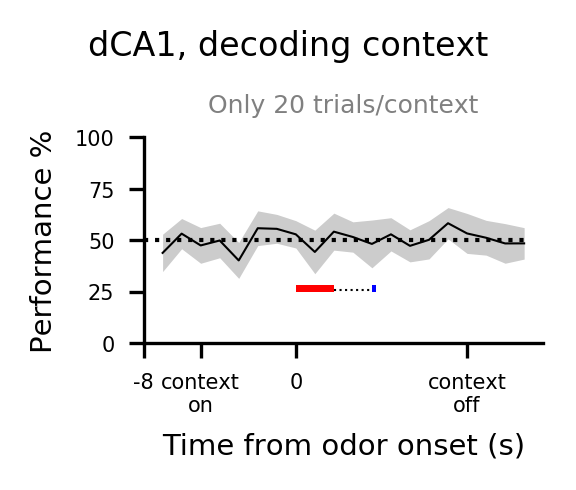

In [40]:
fig, ax = pl.subplots(figsize=(2, 1.5))

ax.plot([(t-7) for t in range(20)], [(np.mean(eval("scores_tb_%s_contextAvsB[sess]"%t))*100) for t in range(20)],
           color='k', ls='-',lw=.5, zorder=19 ,ms=1)
m = np.array([(np.mean(eval("scores_tb_%s_contextAvsB[sess]"%t))*100) for t in range(20)])
s = np.array([np.std(eval("scores_tb_%s_contextAvsB[sess]"%t))*100 for t in range(20)])
ax.fill_between([(t-7) for t in range(20)],m-s,m+s,alpha=0.2,color='k',linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-8, 13)
ax.set_xticks([-8,-5,0,9])
ax.set_xticklabels(['-8','context\non','0','context\noff'])
ax.hlines(50, -8,12, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.set_title('Only 20 trials/context', color='grey',fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("dCA1, decoding context", fontsize=8, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_context.pdf'%NOTEBOOK_NAME)

# And now for decoding across time bins! (using distinct trials for train/test)

In [29]:
def combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

In [31]:
%%time
## decode for context
n_loops=15
for t in range(20): # number of time bins
    for c in range(20):
        exec('scores_tb_%s_VS_%s_contextAvsB = {}'%(t,c))
        for sess in sessions:
            print sess,t,c," ",
            eval('scores_tb_%s_VS_%s_contextAvsB'%(t,c))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                  eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,3),
                  n_cells=None) for i in range(n_loops)]]

 context_only 0 0   context_only 0 1   context_only 0 2   context_only 0 3   context_only 0 4   context_only 0 5   context_only 0 6   context_only 0 7   context_only 0 8   context_only 0 9   context_only 0 10   context_only 0 11   context_only 0 12   context_only 0 13   context_only 0 14   context_only 0 15   context_only 0 16   context_only 0 17   context_only 0 18   context_only 0 19   context_only 1 0   context_only 1 1   context_only 1 2   context_only 1 3   context_only 1 4   context_only 1 5   context_only 1 6   context_only 1 7   context_only 1 8   context_only 1 9   context_only 1 10   context_only 1 11   context_only 1 12   context_only 1 13   context_only 1 14   context_only 1 15   context_only 1 16   context_only 1 17   context_only 1 18   context_only 1 19   context_only 2 0   context_only 2 1   context_only 2 2   context_only 2 3   context_only 2 4   context_only 2 5   context_only 2 6   context_only 2 7   context_only 2 8   context_only 2 9   context_only 2 10   context_o

### running the cell below will take over an hour!

#%%time
#n_loops=15
#for t in range(20):
#    for c in range(20):
#        for comp,relab in zip(comparisons,relabels):
#            exec('scores_tb_%s_VS_%s_%s = {}'%(t,c,comp))
#            for sess in sessions:
#                print sess,t,c,comp,
#                print " ",
#                eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
#                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,9),
#                      n_cells=None, relabel=relab) for i in range(n_loops)]]

#%%time
##now train on one set of CS+/CS-, decode on the other
#tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
#tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
#tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
#n_loops=30
#for t in range(20):
#    for c in range(20):
#        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
#            exec('scores_tb_%s_VS_%s_outcome_%s = {}'%(t,c,it))
#            for sess in sessions:
#                print sess,t,c,it,
#                print " ",
#                eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
#                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,9),
#                      n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for outcome endoding, average each idividual comparison
for t in range(20):
    for c in range(20):
        exec("scores_tb_%s_VS_%s_outcome_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

#for outcome endoding, average each idividual comparison
for t in range(20):
    for c in range(20):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4[sess],scores_tb_%s_VS_%s_CS2vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

for t in range(20):
    for comp in comparisons_av:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(20):
        for comp in comparisons_av:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(20):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

#for t in range(20):
#    exec('distinct%s_%s_ttest = {}'%(t,comp))
#for sess in sessions:
#    for t in range(20):
#        exec("distinct%s_%s_ttest['%s'] = []"%(t,sess))
#        for c in range(20):
#            eval('distinct%s_%s_ttest'%t)[sess].insert(c,
#                (sstats.ttest_1samp(eval('scores_gmin_tb_distinct_%s_VS_%s[sess].mean(1)[:15]'%(t,c)),.5)))
#        for x,i in zip(eval('distinct%s_%s_ttest'%t)[sess],range(len(eval('distinct%s_%s_ttest'%t)[sess]))):
#            exec("distinct%s_%s_ttest[sess][i] = x[-1]"%(t)) #only take p-values

for t in range(20):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(20):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(20):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in comparisons_av:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

for comp in comparisons_av:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

In [32]:
for t in range(20):
    for comp in ['contextAvsB']:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(20):
        for comp in ['contextAvsB']:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(20):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

In [33]:
for t in range(20):
    for comp in ['contextAvsB']:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(20):
        for comp in ['contextAvsB']:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(20):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [34]:
for comp in ['contextAvsB']:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess], distinct14_%s[sess], distinct15_%s[sess], distinct16_%s[sess],distinct17_%s[sess],distinct18_%s[sess],\
              distinct19_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

In [35]:
for comp in ['contextAvsB']:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess], distinct14_%s_wilcox[sess], distinct15_%s_wilcox[sess], distinct16_%s_wilcox[sess], distinct17_%s_wilcox[sess],\
               distinct18_%s_wilcox[sess], distinct19_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

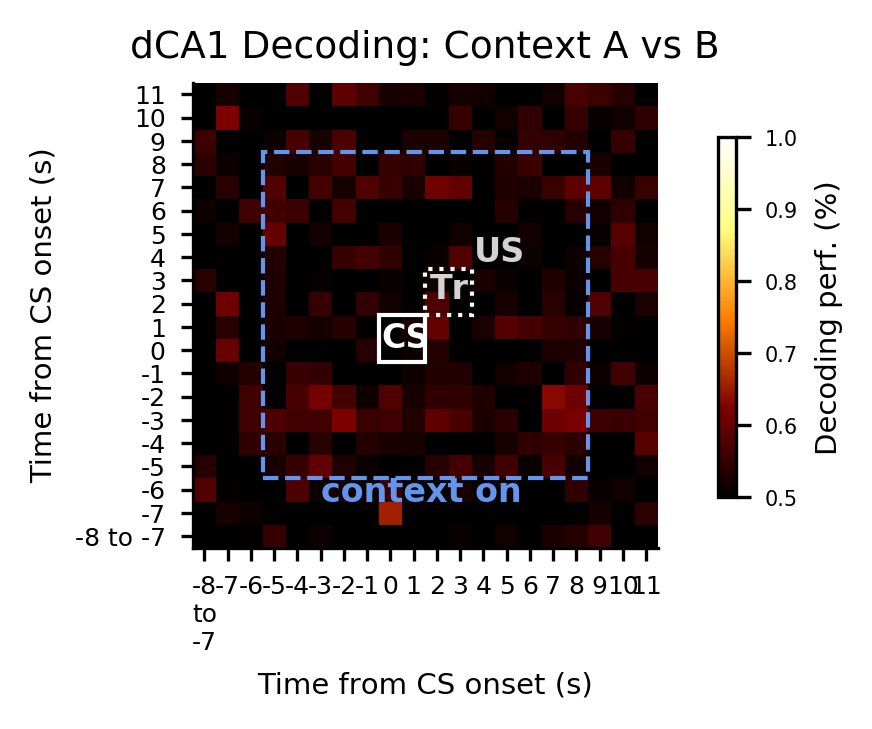

In [37]:
fig, ax = pl.subplots(figsize=(2, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
im = ax.imshow(distinct_contextAvsB['context_only'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
ax.set_xticks(range(20))
ax.set_yticks(range(20))
#ax.set_ylim(2.5, 13.5)
#ax.set_xlim(2.5,13.5)
ax.set_xticklabels(['-8\nto\n-7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10','11','12'],fontsize=6)
ax.set_yticklabels(['-8 to -7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10','11','12'],fontsize=6)
ax.set_ylabel('Time from CS onset (s)', fontsize=7)
ax.set_xlabel('Time from CS onset (s)', fontsize=7)
ax.set_title('dCA1 Decoding: Context A vs B',fontsize=9,color='k')
ax.tick_params(length=3)

import matplotlib.patches as patches
# Create a Rectangle patch
CS = patches.Rectangle((7.5,7.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
Tr = patches.Rectangle((9.5,9.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
Context = patches.Rectangle((2.5,2.5),14,14,linewidth=1,edgecolor='cornflowerblue',facecolor='none',linestyle='--')
# Add the patch to the Axes
ax.add_patch(CS)
ax.add_patch(Tr)
ax.add_patch(Context)
#ax.hlines(25+1, 2, 4, color='b', lw=0.5, linestyles='dotted')

ax.text(5,1.5,"context on",fontsize=8, weight='bold', color='cornflowerblue')
ax.text(7.6,8.1,"CS",fontsize=8, weight='bold', color='w')
ax.text(9.7,10.2,"Tr",fontsize=8, weight='bold', color='lightgray')
ax.text(11.6,11.8,"US",fontsize=8, weight='bold', color='lightgray')

#pl.suptitle('dCA1 Decoding Performance: Context A vs B',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.03, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
#fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_distinct_CSPvsCSM.jpg'%NOTEBOOK_NAME)

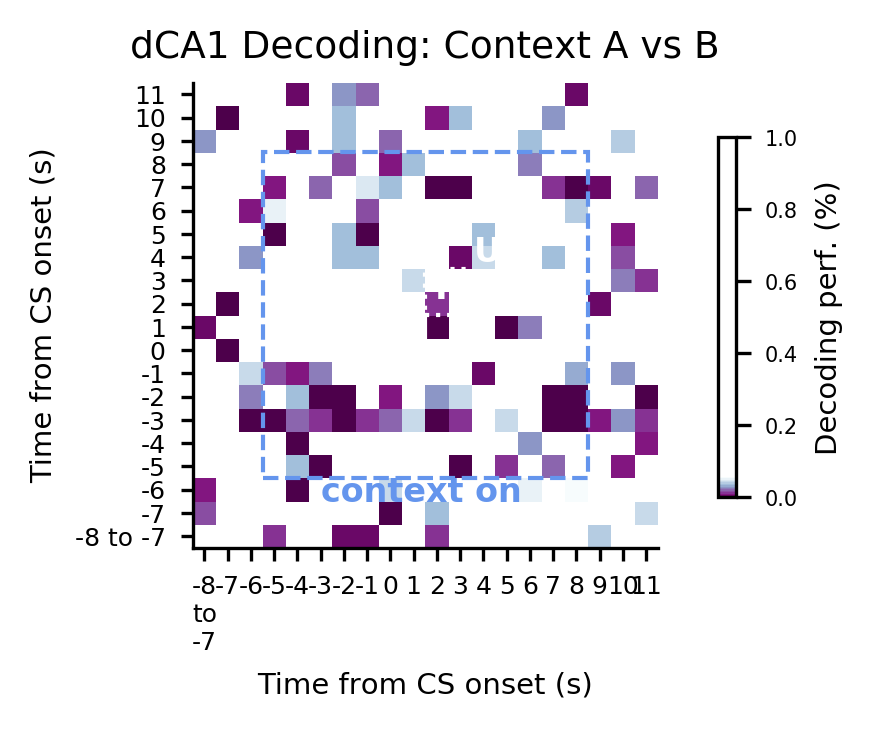

In [38]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(figsize=(2, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
im = ax.imshow(distinct_contextAvsB_wilcox['context_only'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
ax.set_xticks(range(20))
ax.set_yticks(range(20))
#ax.set_ylim(2.5, 13.5)
#ax.set_xlim(2.5,13.5)
ax.set_xticklabels(['-8\nto\n-7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10','11','12'],fontsize=6)
ax.set_yticklabels(['-8 to -7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10','11','12'],fontsize=6)
ax.set_ylabel('Time from CS onset (s)', fontsize=7)
ax.set_xlabel('Time from CS onset (s)', fontsize=7)
ax.set_title('dCA1 Decoding: Context A vs B',fontsize=9,color='k')
ax.tick_params(length=3)

import matplotlib.patches as patches
# Create a Rectangle patch
CS = patches.Rectangle((7.5,7.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
Tr = patches.Rectangle((9.5,9.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
Context = patches.Rectangle((2.5,2.5),14,14,linewidth=1,edgecolor='cornflowerblue',facecolor='none',linestyle='--')
# Add the patch to the Axes
ax.add_patch(CS)
ax.add_patch(Tr)
ax.add_patch(Context)
#ax.hlines(25+1, 2, 4, color='b', lw=0.5, linestyles='dotted')

ax.text(5,1.5,"context on",fontsize=8, weight='bold', color='cornflowerblue')
ax.text(7.6,8.1,"CS",fontsize=8, weight='bold', color='w')
ax.text(9.7,10.2,"Tr",fontsize=8, weight='bold', color='w')
ax.text(11.6,11.8,"US",fontsize=8, weight='bold', color='w')

#pl.suptitle('dCA1 Decoding Performance: Context A vs B',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.03, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
#fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_distinct_CSPvsCSM.jpg'%NOTEBOOK_NAME)

In [41]:
save_workspace(db)

Could not store variable 'patches'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
